In [3]:
%load_ext autoreload
%autoreload 2
import h5py
import os.path as osp
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import iled
data_path = '/home/tau/emenier/data/iLED_public/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
dataset = iled.data_utils.FHNDataset(osp.join(data_path,'data'),'train')

In [5]:
encoder_config = iled.cnn1d.CNN1DEncoderConfig(
                    activation=nn.ReLU(),
                    activation_output=nn.Identity(),
                    kernel_size=5,
                    dim_input = 101,dim_latent=2,
                    layer_channels=[2,8,16,32,4],
                    latent_centering=True)
decoder_config = iled.cnn1d.CNN1DDecoderConfig(
                    activation = nn.ReLU(),
                    activation_output = iled.activations.TanhPlus(),
                    kernel_size = 5,
                    dim_input = 101,
                    dim_latent = 2,
                    layer_channels = [4,32,16,8,2],
                    unflatten_shape = (4,8),
                    bias = True)
scaler_config = iled.scalers.MinMaxScalerConfig(data_min=dataset.data_min, data_max=dataset.data_max)

In [6]:
ae_config = iled.autoencoders.ScaledAutoEncoderConfig(encoder_config,decoder_config,scaler_config)

In [7]:
dynamics_config = iled.splitdynamics.SplitDynamicsConfig(
                    dim_latent=2,dim_hidden = 32,activation=nn.ReLU(),
                    linear_operator='dissipative',nl_operator='memory_only',
                    nl_width = 64, default_substeps = 2
                    )

In [8]:
end_to_end_config = iled.endtoend.EndToEndConfig(n_warmup=15,init_nTmax=20,substeps=2,
                                                ae_config=ae_config,dynamics_config=dynamics_config)

In [49]:
import iled
model = end_to_end_config.make().to(torch.float)

In [50]:
loader = DataLoader(dataset,batch_size=32,shuffle=True)
batch = next(iter(loader))
ret = model(batch.to(torch.float))

In [74]:
losses_and_scales = {'reconstruction':['mse',1],
              'latent_forecast':['mse',1e-1],
              'reconstructed_forecast':['mse',1e-1],
              'nl_penalisation_loss':['mse',1e-4]}
trainer_config = iled.trainer.TrainerConfig(model_config =end_to_end_config,
                                            losses_and_scales=losses_and_scales,
                                            dtype=torch.float,
                                            save_path=osp.join(data_path,'runs','run1'),
                                            lr=3e-4,weight_decay=1e-6,
                                            max_patience=50, t_increment_patience=10,
                                            target_length = 120,
                                            cuda = torch.cuda.is_available(),
                                            validate_every=2, checkpoint_every=100)

In [75]:
trainer_config.losses_and_scales

{'reconstruction': ['mse', 1],
 'latent_forecast': ['mse', 0.1],
 'reconstructed_forecast': ['mse', 0.1],
 'nl_penalisation_loss': ['mse', 0.0001]}

In [76]:
trainer = trainer_config.make()

In [77]:
train_dataset = iled.data_utils.FHNDataset(osp.join(data_path,'data'),'train')
val_dataset = iled.data_utils.FHNDataset(osp.join(data_path,'data'),'val')

In [78]:
train_loader = DataLoader(train_dataset,batch_size=32,shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=32,shuffle=True)

In [79]:
trainer.train(train_loader,val_loader)

Epoch 0 | Train | nTmax : 20, 4.468e-01: 100%|██████████| 30/30 [00:10<00:00,  2.98it/s]
Epoch 0 | Val | nTmax : 20, 4.365e-01: 100%|██████████| 20/20 [00:02<00:00,  7.36it/s]
Epoch 1 | Train | nTmax : 20, 4.108e-01: 100%|██████████| 30/30 [00:10<00:00,  2.86it/s]
Epoch 2 | Train | nTmax : 20, 3.071e-01: 100%|██████████| 30/30 [00:10<00:00,  2.92it/s]
Epoch 2 | Val | nTmax : 20, 2.428e-01: 100%|██████████| 20/20 [00:02<00:00,  7.06it/s]
Epoch 3 | Train | nTmax : 20, 1.972e-01: 100%|██████████| 30/30 [00:10<00:00,  2.91it/s]
Epoch 4 | Train | nTmax : 20, 1.021e-01: 100%|██████████| 30/30 [00:10<00:00,  2.77it/s]
Epoch 4 | Val | nTmax : 20, 6.537e-02: 100%|██████████| 20/20 [00:02<00:00,  7.10it/s]
Epoch 5 | Train | nTmax : 20, 4.911e-02: 100%|██████████| 30/30 [00:10<00:00,  2.88it/s]
Epoch 6 | Train | nTmax : 20, 2.867e-02: 100%|██████████| 30/30 [00:10<00:00,  2.95it/s]
Epoch 6 | Val | nTmax : 20, 2.240e-02: 100%|██████████| 20/20 [00:02<00:00,  7.28it/s]
Epoch 7 | Train | nTmax : 20,

KeyboardInterrupt: 

In [24]:
z = ae.transform(dataset[0].to(torch.float))
x = ae.inverse_transform(z)

In [33]:
ae = ae_config.make().to(torch.float).cuda()
opt = torch.optim.Adam(ae.parameters(),lr=3e-4,weight_decay=1e-6)
loader = DataLoader(dataset,batch_size=32,shuffle=True)
lossfunc = nn.MSELoss()
losses = []
while True:
    print('New epoch')
    for i, batch in enumerate(loader):
        opt.zero_grad()
        batch = batch.to(torch.float).cuda()
        z = ae.transform_batch(batch)
        x = ae.inverse_transform_batch(z)
        loss = lossfunc(x,batch)
        loss.backward()
        opt.step()
        losses.append(loss.item())
        if i%10 ==0:
            print(f'{losses[-1]:.3e}')

New epoch
4.130e-01
4.053e-01
3.977e-01
New epoch
3.827e-01
3.689e-01
3.456e-01
New epoch
3.137e-01
2.783e-01
2.350e-01
New epoch
1.865e-01
1.420e-01
9.900e-02
New epoch
6.186e-02
4.831e-02
3.222e-02
New epoch
2.489e-02
1.852e-02
1.335e-02
New epoch
9.919e-03
8.115e-03
7.161e-03
New epoch
5.844e-03
5.126e-03
4.924e-03
New epoch
4.548e-03
4.427e-03
4.282e-03
New epoch
4.140e-03
4.058e-03
3.930e-03
New epoch
4.025e-03
3.870e-03
3.866e-03
New epoch
3.706e-03
3.773e-03
3.603e-03
New epoch
3.557e-03
3.425e-03
3.492e-03
New epoch
3.402e-03
3.370e-03
3.341e-03
New epoch
3.377e-03
3.276e-03
3.252e-03
New epoch
3.298e-03
3.370e-03
3.328e-03
New epoch
3.212e-03
3.271e-03
3.250e-03
New epoch
3.184e-03
3.250e-03
3.138e-03
New epoch
3.171e-03
3.146e-03
3.266e-03
New epoch
3.157e-03
3.081e-03
3.161e-03
New epoch
3.155e-03
2.988e-03
3.034e-03
New epoch
3.183e-03
3.075e-03
3.027e-03
New epoch
2.998e-03
3.117e-03
3.069e-03
New epoch
3.001e-03
2.931e-03
3.023e-03
New epoch
2.930e-03
2.982e-03
3.005e-03


KeyboardInterrupt: 

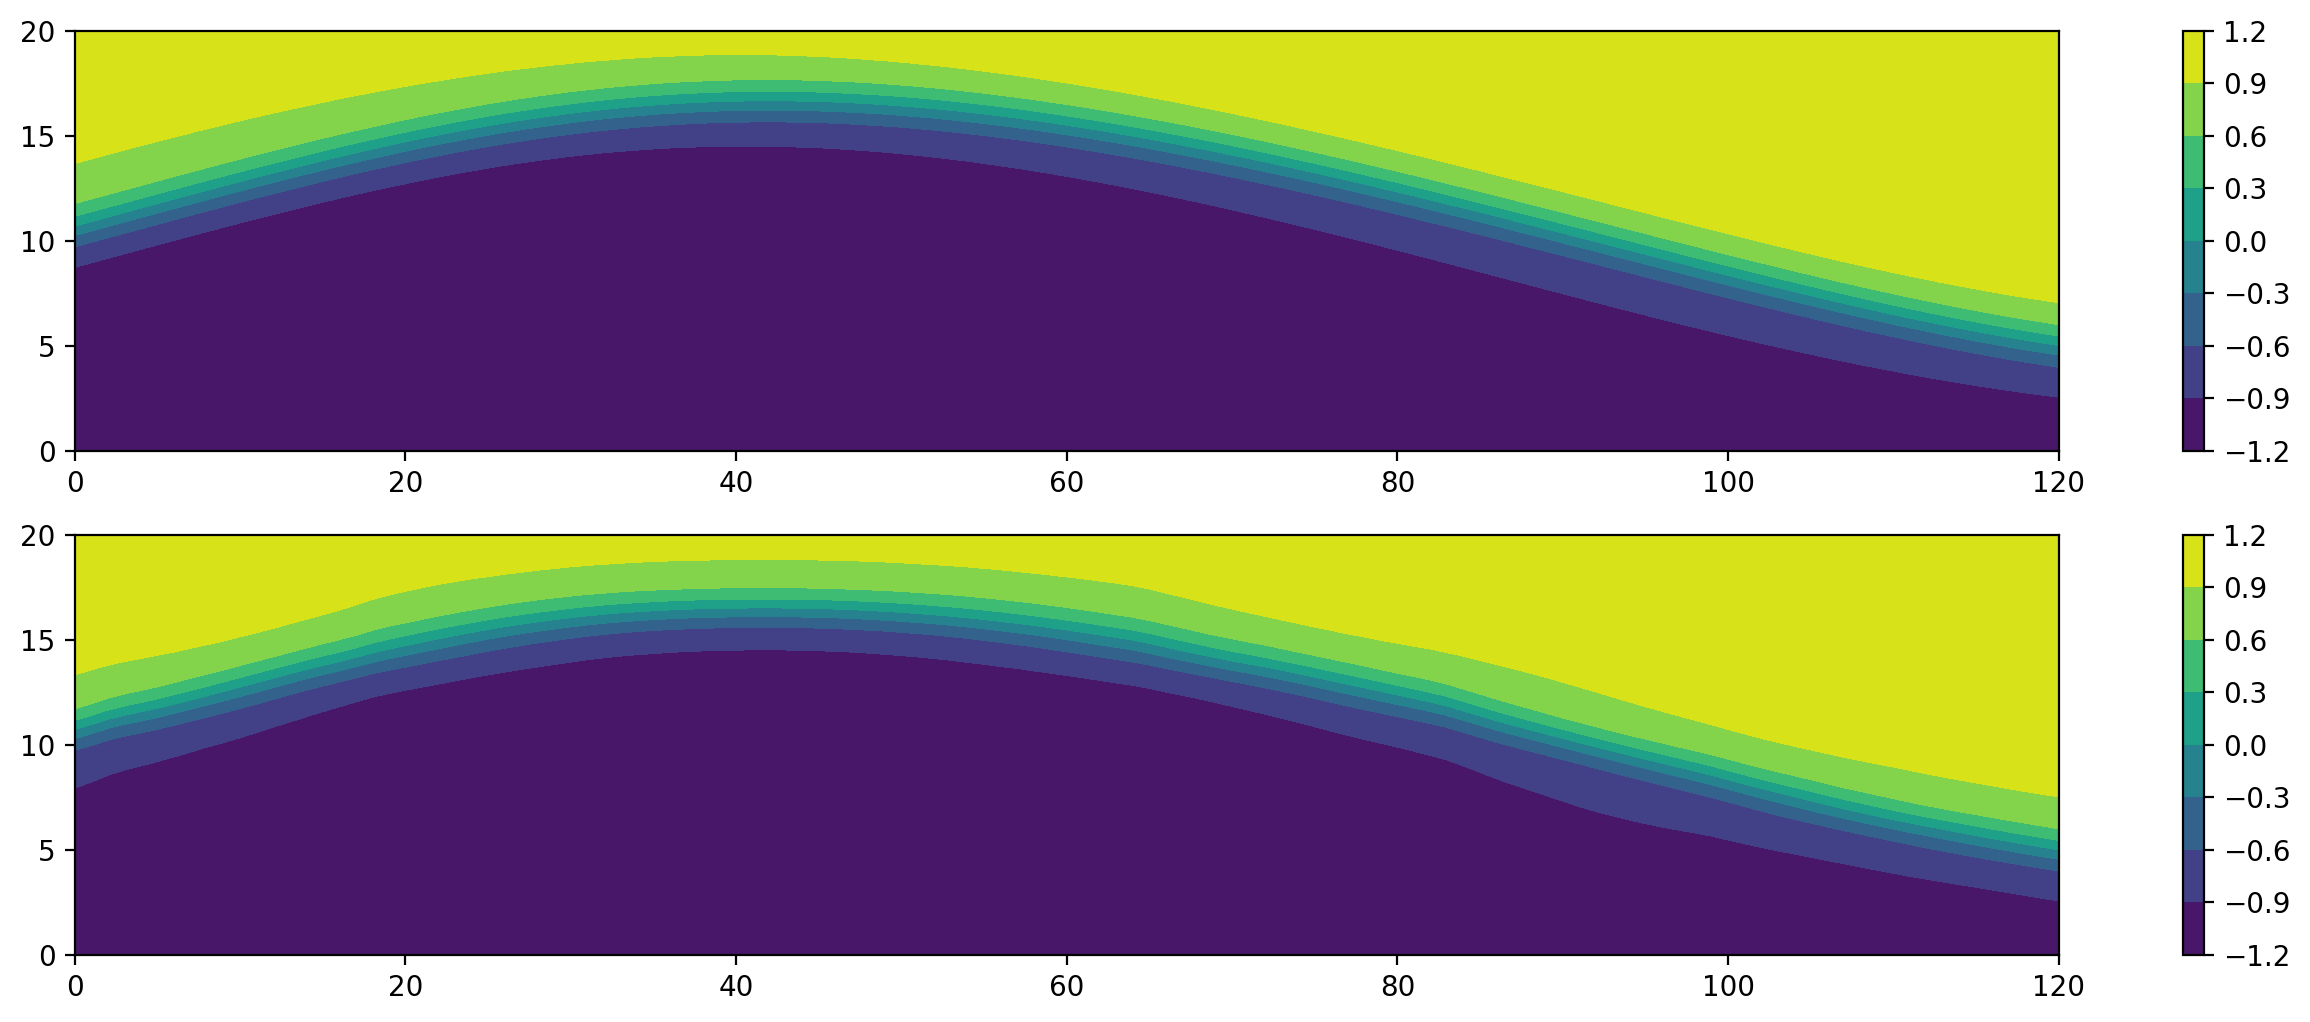

In [48]:
data = dataset[np.random.choice(len(dataset))]
reconstruction = ae.inverse_transform(ae.transform(data.to(torch.float).cuda())).detach().cpu()
x = np.linspace(0,20,data.shape[-1])
fig, (ax1,ax2) = plt.subplots(nrows=2,figsize=(16,6),dpi=200)
ola=ax1.contourf(np.arange(data.shape[0]),x,data[:,0,:].t())
plt.colorbar(ola)
ola=ax2.contourf(np.arange(data.shape[0]),x,reconstruction[:,0,:].t())
plt.colorbar(ola)